$V(x,y) = \frac{1}{2}\left(x^2+y^2\right) + \lambda \left(x^2y+\frac{y^3}{3}\right)$

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib
import pImpactR as impact

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
lambda_setting = 2.0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pImpactR.util import naff 
ny = 128
npy = 128
radi2 = 100
npt = ny*npy
nturn = 1024*2
nsteps = 10000
dt = 1/nsteps

In [4]:
def getV(x,y,lam):
    return 0.5*(x*x+y*y) + lam*(x*x*y + y*y*y/3.0)

def getH(px,py,x,y,lam):
    return 0.5*(px*px+py*py)+getV(x,y,lam)

def getK(px,py,x,y,lam):
    return px*py + x*y + lam*(x*y*y + x*x*x/3.0)

In [5]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [6]:
def drift(x,px,y,py,dt):
    x = x + px*dt
    y = y + py*dt
    return x,y

def kick(x,px,y,py,lam,dt):
    px = px - dt*(x + lam*2*x*y)
    py = py - dt*(y + lam*(x*x  +y*y))
    return px,py
    
def oneStep(x,px,y,py,lam,dt):
    x,y = drift(x,px,y,py,0.5*dt)
    px,py = kick(x,px,y,py,lam,dt)
    x,y = drift(x,px,y,py,0.5*dt)
    return x,px,y,py

def multiStep(x,px,y,py,lam,dt,nsteps):
    x,y = drift(x,px,y,py,0.5*dt)
    for i in range(nsteps-1):
        px,py = kick (x,px,y,py,lam,dt)
        x,y   = drift(x,px,y,py,dt)
    px,py = kick (x,px,y,py,lam,dt)
    x,y   = drift(x,px,y,py,0.5*dt)
    return x,px,y,py
    
# def checkLost(x,px,y,py):
#     ilive = x*x+y*y < radi2
#     x = x[ilive]
#     y = y[ilive]
#     px= px[ilive]
#     py= py[ilive]
#     return x,px,y,py    

In [7]:
def Init(energy,lam):
    y = []
    py= []
    px= []
    i=0
    for y0 in np.linspace(-0.5,0.8,ny):
        for py0 in np.linspace(-0.5,0.5,npy):
            px2 = 2*energy - py0*py0 - y0*y0 - lam*(2.0/3.0)*y0**3
            if px2 >= 0.0:
                y.append(y0)
                py.append(py0)
                px.append(np.sqrt(px2))
                
    npt = len(y)
    print(npt)
    x =np.zeros(npt)
    y =np.array(y)
    px=np.array(px)
    py=np.array(py)
                
    return x,px,y,py

In [8]:
def runFoward(x,px,y,py,lam,nturn):
    ilive = x*x+y*y < radi2
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    Invs = np.zeros([nturn,npt,2])
    data[0,:,0] = x[:]
    data[0,:,1] = px[:]
    data[0,:,2] = y[:]
    data[0,:,3] = py[:]
    Invs[0,:,0] = getH(px,py,x,y,lam)
    Invs[0,:,1] = getK(px,py,x,y,lam)
    for i in range(1,nturn):
        x,px,y,py = multiStep(x,px,y,py,lam,dt,nsteps)
        ilive = np.logical_and(ilive,x*x+y*y < radi2)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
        Invs[i,:,0] = getH(px,py,x,y,lam)
        Invs[i,:,1] = getK(px,py,x,y,lam)
    return data[:,ilive,:],Invs[:,ilive,:]

In [9]:
def runBackward(x,px,y,py,lam,nturn):
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    for i in range(nturn):
        x,px,y,py = multiStep(x,px,y,py,lam,-dt,nsteps)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
    return data

In [10]:
def runPoincare(energy,y,py,lam,dt,nsample):
    px2 = 2*energy - py*py - y*y - lam*(2.0/3.0)*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    Y = np.zeros(nsample)
    Py= np.zeros(nsample)
    Y [0] = y
    Py[0] =py
    i=1
    h=dt
    while (i<nsample):
        x,px,y,py = oneStep(x,px,y,py,lam,h)
        if np.abs(x) < 1.0e-6:
            Y [i]= y
            Py[i]=py
            i=i+1
            h=dt
        elif x*px < 0:
            if np.abs(x) < 1.0e-5:
                h=0.001*dt
            elif np.abs(x) < 1.0e-4:
                h=0.01*dt
            elif np.abs(x) < 1.0e-3:
                h=0.1*dt
        else:
            h=dt
    return Y,Py

In [11]:
def runFB(energy,y,py,lam,dt,nturn):
    px2 = 2*energy - py*py - y*y - lam*2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    
    tmp = np.zeros([nturn,4])
    data = np.zeros([nturn])
    for i in range(nturn):
        tmp[i,0] = x
        tmp[i,1] =px
        tmp[i,2] = y
        tmp[i,3] =py
        x,px,y,py = multiStep(x,px,y,py,lam,dt,nsteps)  
    for iturn in range(1,nturn):
        x = tmp[iturn,0]
        px= tmp[iturn,1]
        y = tmp[iturn,2]
        py= tmp[iturn,3]
        for jturn in range(iturn):
            x,px,y,py = multiStep(x,px,y,py,lam,-dt,nsteps)
        data[iturn] = np.sqrt( (x -tmp[0,0])**2
                              +(y -tmp[0,2])**2
                              +(px-tmp[0,1])**2
                              +(py-tmp[0,3])**2 )

        
    return data

In [12]:
def runFB_ave(energy,y,py,lam,dt,nturn,ave_ratio):
    px2 = 2*energy - py*py - y*y - lam*2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    
    tmp = np.zeros([nturn,4])
    data = np.zeros([nturn])
    for i in range(nturn):
        tmp[i,0] = x
        tmp[i,1] =px
        tmp[i,2] = y
        tmp[i,3] =py
        x,px,y,py = multiStep(x,px,y,py,lam,dt,nsteps)  
    for iturn in range(1,nturn):
        x = tmp[iturn,0]
        px= tmp[iturn,1]
        y = tmp[iturn,2]
        py= tmp[iturn,3]
        ave_turns = np.max([round(ave_ratio*iturn),1])
        for jturn in range(iturn):
            x,px,y,py = multiStep(x,px,y,py,lam,-dt,nsteps)
            if iturn-jturn <= ave_turns:
                data[iturn] = data[iturn] + np.sqrt( (x -tmp[iturn-jturn-1,0])**2
                                                    +(y -tmp[iturn-jturn-1,2])**2
                                                    +(px-tmp[iturn-jturn-1,1])**2
                                                    +(py-tmp[iturn-jturn-1,3])**2 )
        data[iturn] = data[iturn]/ave_turns
    return data

# Frequencies along lines

In [13]:
def eval_lines(lam,n):
    x=np.zeros(n)
    y=np.zeros(n)
    T = np.linspace(-1.0/lam,0.5/lam,n)
    for i,t in enumerate(T):
        x[i] = 0.5*t + 0.25/lam
        y[i] = 0.5*t - 0.25/lam
    return x,y

(256,)


(-1.1, 0.5)

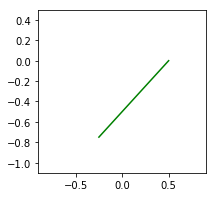

In [14]:
npt=256
nturn = 1024
x,y = eval_lines(lambda_setting,npt)
print(x.shape)
plt.figure(figsize=(3,3))
plt.plot(lambda_setting*x,lambda_setting*y,c='green')
plt.grid
plt.xlim([-0.9,0.9])
plt.ylim([-1.1,0.5])

In [15]:
data,invs = runFoward(x,np.zeros(npt),y,np.zeros(npt),lambda_setting,2*nturn) 

/home/kileanhwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [16]:
invs.shape

(2048, 254, 2)

(-1.1, 0.5)

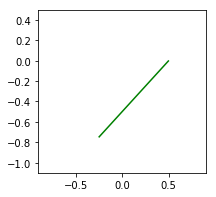

In [17]:
plt.figure(figsize=(3,3))
plt.plot(lambda_setting*data[0,:,0],lambda_setting*data[0,:,2],c='green')
plt.grid
plt.xlim([-0.9,0.9])
plt.ylim([-1.1,0.5])

In [18]:
invs[:,0,0]

array([0.03124785, 0.03124785, 0.03124785, ..., 0.03124785, 0.03124785,
       0.03124785])

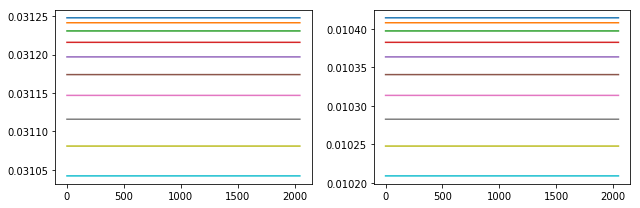

In [21]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
for i in range(10):
    plt.plot(invs[:,i,0])
plt.subplot(1,2,2)
for i in range(10):
    plt.plot(invs[:,i,1])
plt.tight_layout()

In [25]:
dum,npt,dum = data.shape

In [77]:
X = np.zeros([2*nturn,npt],dtype=np.complex64)
Y = np.zeros([2*nturn,npt],dtype=np.complex64)
for i in range(2*nturn):
    X[i,:] = data[i,:,0] - 1j*data[i,:,1]
    Y[i,:] = data[i,:,2] - 1j*data[i,:,3]

In [78]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

In [68]:
ref = np.loadtxt('w1table.data')

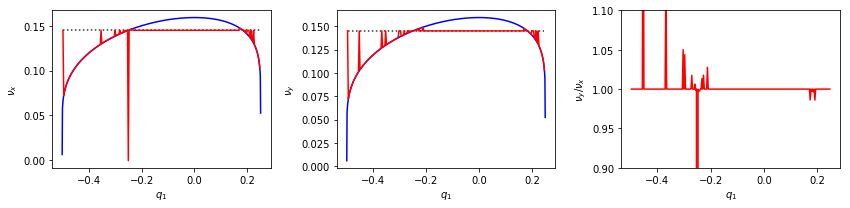

In [79]:
# ticks = np.array([.2,.4,.6,.8,1.,1.2,1.4])
nu2 = 0.91039/(2*np.pi)
min_q1 = (np.real(X[0,:])+np.real(Y[0,:])).min()
max_q1 = (np.real(X[0,:])+np.real(Y[0,:])).max()
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot([min_q1,max_q1],[nu2,nu2],'k:',alpha=0.8)
plt.plot(ref[:,0],ref[:,1]/(2*np.pi),'b')
plt.plot(np.real(X[0,:])+np.real(Y[0,:]),tuneX,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_x$');
# plt.ylim((0,1.5))
# plt.yticks(ticks)
plt.subplot(1,3,2)
plt.plot([min_q1,max_q1],[nu2,nu2],'k:',alpha=0.8)
plt.plot(ref[:,0],ref[:,1]/(2*np.pi),'b')
plt.plot(np.real(X[0,:])+np.real(Y[0,:]),tuneY,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_y$');
# plt.yticks(2*ticks)
# plt.ylim(0,3.0)
plt.subplot(1,3,3)
plt.plot(np.real(X[0,:])+np.real(Y[0,:]),tuneY/tuneX,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_y/\nu_x$');
plt.ylim(0.9,1.1)
plt.tight_layout()
plt.savefig('w1plot.png',dip=180)

In [39]:
0.91039/(2*np.pi)

0.14489306864143062

In [70]:
Q1 = np.zeros([2*nturn,npt],dtype=np.complex64)
Q2 = np.zeros([2*nturn,npt],dtype=np.complex64)
for i in range(2*nturn):
    Q1[i,:] = data[i,:,0]+data[i,:,2] - 1j*(data[i,:,1]+data[i,:,3])/2
    Q2[i,:] = data[i,:,0]-data[i,:,2] - 1j*(data[i,:,1]-data[i,:,3])/2

In [74]:
tuneQ1 = np.zeros(npt)
tuneQ2 = np.zeros(npt)
for i in range(npt):
    signal = Q1[:,i] - Q1[:,i].mean()
    tuneQ1[i], amp, dummy = impact.util.naff(1,signal)
    signal = Q2[:,i] - Q2[:,i].mean()
    tuneQ2[i], amp, dummy = impact.util.naff(1,signal)

In [33]:
ref = np.loadtxt('w1table.data')

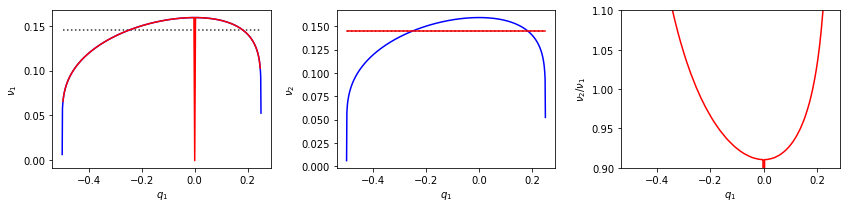

In [80]:
# ticks = np.array([.2,.4,.6,.8,1.,1.2,1.4])
nu2 = 0.91039/(2*np.pi)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot([min_q1,max_q1],[nu2,nu2],'k:',alpha=0.8)
plt.plot(ref[:,0],ref[:,1]/(2*np.pi),'b')
plt.plot(np.real(Q1[0,:]),tuneQ1,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_1$');
# plt.ylim((0,1.5))
# plt.yticks(ticks)
plt.subplot(1,3,2)
plt.plot([min_q1,max_q1],[nu2,nu2],'k:',alpha=0.8)
plt.plot(ref[:,0],ref[:,1]/(2*np.pi),'b')
plt.plot(np.real(X[0,:])+np.real(Y[0,:]),tuneQ2,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_2$');
# plt.yticks(2*ticks)
# plt.ylim(0,3.0)
plt.subplot(1,3,3)
plt.plot(np.real(X[0,:])+np.real(Y[0,:]),tuneQ2/tuneQ1,'r')
plt.xlabel('$q_1$');
plt.ylabel(r'$\nu_2/\nu_1$');
plt.ylim(0.9,1.1)
plt.tight_layout()
plt.savefig('w1plot.using_normal_coord.png',dip=180)

In [ ]:
# DA

dataF = [0]*2
dataB = [0]*2
cFMA  = [0]*2
cFB   = [0]*2
dataFB= [0]*2
dataFBave = [0]*2
poinY = [0]*2
poinPy= [0]*2
Energy= [1.0/12.0, 1.0/9.0]

# regular: E=1/12

n=0
energy = Energy[n]
x,px,y,py = Init(energy,2.0)
dataF[n] = runFoward  (x,px,y,py,2.0,2*nturn) 
x = dataF[n][nturn,:,0]
px= dataF[n][nturn,:,1]
y = dataF[n][nturn,:,2]
py= dataF[n][nturn,:,3]
dataB[n] = runBackward(x,px,y,py,2.0,  nturn)

##### FMA

dummy,npt,dummy = dataF[n].shape
X = dataF[n][:,:,0] - 1j*dataF[n][:,:,1]
Y = dataF[n][:,:,2] - 1j*dataF[n][:,:,3]
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Xdiff = np.zeros(npt)
Ydiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Xdiff[i] = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Ydiff[i] = getClosestDiff(tuneYbefore[i],tune)

cFMA[n] = np.sqrt(Xdiff**2 +Ydiff**2)
cFMA[n] = np.log10(cFMA[n]+1.0e-6)

ymin = dataF[n][0,:,2].min()
ymax = dataF[n][0,:,2].max()
pymin= dataF[n][0,:,3].min()
pymax= dataF[n][0,:,3].max()
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFMA[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### FB

cFB[n] = np.log10(np.sqrt(np.sum( (dataF[n][0,:,:]-dataB[n][-1,:,:])**2, axis=1)))

fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFB[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### Poincare

poinY[n],poinPy[n] = runPoincare(energy,-0.15,0.0,2.0,1.0e-3,2048*4)

fig = plt.figure(figsize=[4,3.3])
plt.scatter(poinY[n],poinPy[n],s=1)
# plt.xlim( ymin*1.1, ymax*1.1)
# plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')

# regular: E=1/9

n=1
energy = Energy[n]
x,px,y,py = Init(energy)
dataF[n] = runFoward  (x,px,y,py,2.0,2*nturn) 
x = dataF[n][nturn,:,0]
px= dataF[n][nturn,:,1]
y = dataF[n][nturn,:,2]
py= dataF[n][nturn,:,3]
dataB[n] = runBackward(x,px,y,py,2.0,  nturn)

##### FMA

dummy,npt,dummy = dataF[n].shape
X = dataF[n][:,:,0] - 1j*dataF[n][:,:,1]
Y = dataF[n][:,:,2] - 1j*dataF[n][:,:,3]
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Xdiff = np.zeros(npt)
Ydiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Xdiff[i] = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Ydiff[i] = getClosestDiff(tuneYbefore[i],tune)

cFMA[n] = np.sqrt(Xdiff**2 +Ydiff**2)
cFMA[n] = np.log10(cFMA[n]+1.0e-6)

ymin = dataF[n][0,:,2].min()
ymax = dataF[n][0,:,2].max()
pymin= dataF[n][0,:,3].min()
pymax= dataF[n][0,:,3].max()
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFMA[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### FB

cFB[n] = np.log10(np.sqrt(np.sum( (dataF[n][0,:,:]-dataB[n][-1,:,:])**2, axis=1)))

fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFB[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### Poincare

poinY[n],poinPy[n] = runPoincare(energy,-0.15,0.0,2.0,1.0e-3,2048*4)

fig = plt.figure(figsize=[4,3.3])
plt.scatter(poinY[n],poinPy[n],s=1)
# plt.xlim( ymin*1.1, ymax*1.1)
# plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')